<a href="https://colab.research.google.com/github/Satvik713/SAiDL/blob/master/VAE_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='./mnist_data/', train = True, transform = transform, download = True)
test_set= datasets.MNIST(root='./mnist_data', train = False, transform = transform, download= False)

batch_size = 128
train_data_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_data_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 278859437.42it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101114936.41it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 141777191.40it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23872843.07it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
#The variational autoencoder class
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()

    self.encoder1 = nn.Linear(784, 512)
    # self.bn1 = nn.BatchNorm1d(512)
    self.encoder2 = nn.Linear(512, 256)
    self.mu = nn.Linear(256, 2)
    self.log_var = nn.Linear(256, 2)
    self.decoder3 = nn.Linear(2, 256)
    self.decoder4 = nn.Linear(256, 512)
    self.decoder5 = nn.Linear(512, 784)

  def encoder(self, input):
    en1 = F.relu(self.encoder1(input))
    en2 = F.relu(self.encoder2(en1))
    mu = self.mu(en2)
    log_var = self.log_var(en2)
    return mu, log_var

  def decoder(self, decoded_input):
    dec1 = F.relu(self.decoder3(decoded_input))
    dec2 = F.relu(self.decoder4(dec1))
    dec3 = F.sigmoid(self.decoder5((dec2)))
    return dec3

  def reparameterization(self, mu, log_var):
    std_dev = torch.exp(0.5*log_var)
    epsilon = torch.randn_like(std_dev)
    sample = epsilon.mul(std_dev).add_(mu)
    return sample

  def forward(self, input):
    mu, log_var = self.encoder(input.view(-1, 784))
    sample = self.reparameterization(mu, log_var)
    reconstructed_data = self.decoder(sample)
    return mu, log_var, reconstructed_data

  def generate_samples(self, num_samples, desired_mean=1, desired_std=2):
    with torch.no_grad():
      sample = torch.randn(num_samples, 2).cuda()
      decoded_sample_normal_dist = self.decoder(sample).cuda()

      sample_custom_dist = torch.randn(num_samples, 2).cuda()*desired_std + desired_mean
      decoded_sample_custom_dist = self.decoder(sample_custom_dist).cuda()

      return decoded_sample_normal_dist, decoded_sample_custom_dist

In [ ]:
vae = VAE()
if torch.cuda.is_available():
  vae.cuda()

In [ ]:
vae

VAE(
  (encoder1): Linear(in_features=784, out_features=512, bias=True)
  (encoder2): Linear(in_features=512, out_features=256, bias=True)
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (log_var): Linear(in_features=256, out_features=2, bias=True)
  (decoder3): Linear(in_features=2, out_features=256, bias=True)
  (decoder4): Linear(in_features=256, out_features=512, bias=True)
  (decoder5): Linear(in_features=512, out_features=784, bias=True)
)

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
def loss_function(mu, log_var, input, reconstructed_data):
  reconstruction_loss = F.binary_cross_entropy(reconstructed_data, input.view(-1, 784), reduction = 'sum')
  kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return reconstruction_loss + kl_divergence

In [ ]:
from tqdm import tqdm
vae.train()
for i in range(10):
  training_loss = 0
  for batch_idx, (data, _) in enumerate(tqdm(train_data_loader)):
    data = data.cuda()
    optimizer.zero_grad()
    mu, log_var, reconstructed_data = vae(data)
    loss = loss_function(mu, log_var, data, reconstructed_data)

    loss.backward()
    training_loss += loss.item()
    optimizer.step()
  print('Epoch- {} loss Average loss- {:.5f}'.format(i, training_loss / len(train_data_loader.dataset)))

100%|██████████| 469/469 [00:08<00:00, 53.83it/s]


Epoch- 0 loss Average loss- 182.07174


100%|██████████| 469/469 [00:08<00:00, 57.65it/s]


Epoch- 1 loss Average loss- 159.28984


100%|██████████| 469/469 [00:07<00:00, 60.67it/s]


Epoch- 2 loss Average loss- 153.94913


100%|██████████| 469/469 [00:07<00:00, 61.59it/s]


Epoch- 3 loss Average loss- 150.80714


100%|██████████| 469/469 [00:07<00:00, 58.99it/s]


Epoch- 4 loss Average loss- 148.54087


100%|██████████| 469/469 [00:07<00:00, 61.85it/s]


Epoch- 5 loss Average loss- 147.00840


100%|██████████| 469/469 [00:07<00:00, 59.63it/s]


Epoch- 6 loss Average loss- 145.75949


100%|██████████| 469/469 [00:09<00:00, 49.30it/s]


Epoch- 7 loss Average loss- 144.84878


100%|██████████| 469/469 [00:08<00:00, 58.32it/s]


Epoch- 8 loss Average loss- 143.94670


100%|██████████| 469/469 [00:07<00:00, 63.22it/s]

Epoch- 9 loss Average loss- 143.20758


In [ ]:
vae.eval()
testing_loss = 0
with torch.no_grad():
  for data, _ in test_data_loader:
    data = data.cuda()
    mu, log_var, reconstructed_data = vae(data)

    testing_loss += loss_function(mu, log_var, data, reconstructed_data)

  testing_loss /= len(test_data_loader.dataset)
  print('Test loss- {:.5f}'.format(testing_loss))

Test loss- 144.09940


In [ ]:
std_normal_samples, custom_dist_samples = vae.generate_samples(num_samples=64)

In [ ]:
# with torch.no_grad():
#   sample = torch.randn(64, 2).cuda()
#   decoded_sample = vae.decoder(sample).cuda()
#   decoded_sample = decoded_sample.view(64, 1, 28, 28)
#   grid = vutils.make_grid(decoded_sample, nrow=8, normalize=True)
#   grid_np = grid.cpu().numpy()

#   plt.figure(figsize=(10, 10))
#   plt.imshow(np.transpose(grid_np, (1,2,0)))
#   plt.axis('off')
#   plt.show()


In [ ]:
def sample_visualization(samples, title):
  samples = samples.view(64, 1, 28, 28)
  grid = vutils.make_grid(samples, nrow=8, normalize=True)
  grid_np = grid.cpu().numpy()

  plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(grid_np, (1,2,0)))
  plt.title(title)
  plt.axis('off')
  plt.show()

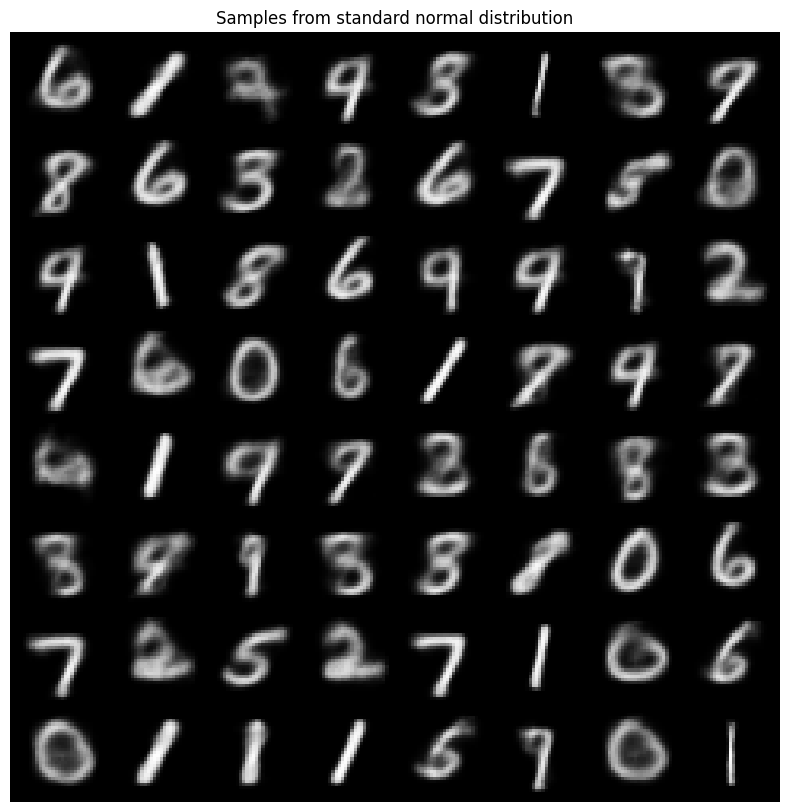

In [ ]:
sample_visualization(std_normal_samples, title='Samples from standard normal distribution')

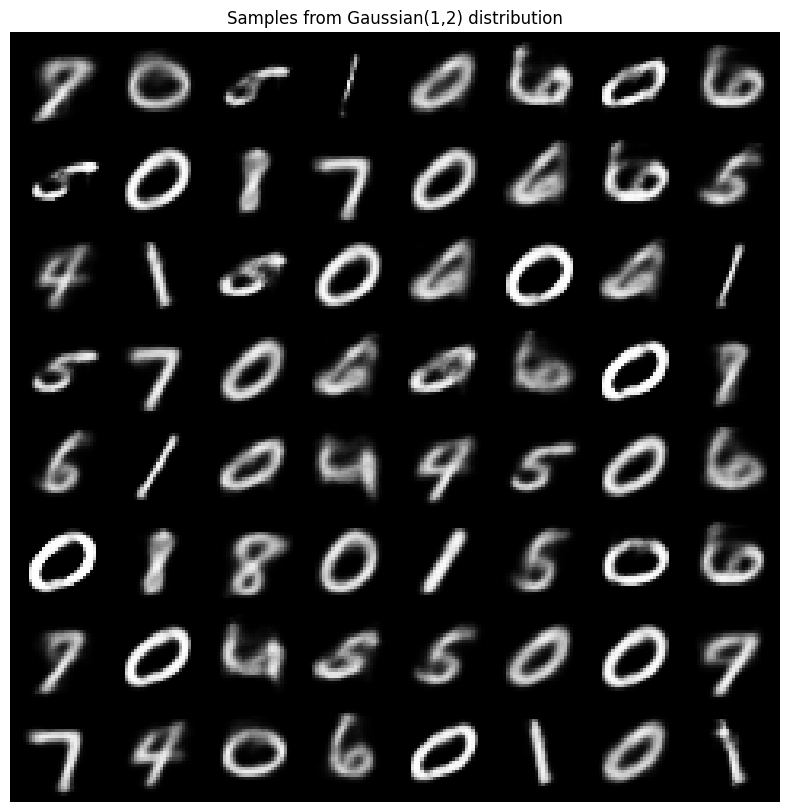

In [ ]:
sample_visualization(custom_dist_samples, title='Samples from Gaussian(1,2) distribution')